In [13]:
import mingus.core.notes as notes
import mingus.core.keys as keys
from mingus.containers import Note
from mingus.midi import fluidsynth
import time

### resources
https://bspaans.github.io/python-mingus/doc/wiki/refMingusContainersNote.html
https://bspaans.github.io/python-mingus/doc/wiki/tutorialNoteContainerModule.html
https://exp-docs.readthedocs.io/en/latest/

In [14]:
keys.major_keys, keys.minor_keys

(['Cb',
  'Gb',
  'Db',
  'Ab',
  'Eb',
  'Bb',
  'F',
  'C',
  'G',
  'D',
  'A',
  'E',
  'B',
  'F#',
  'C#'],
 ['ab',
  'eb',
  'bb',
  'f',
  'c',
  'g',
  'd',
  'a',
  'e',
  'b',
  'f#',
  'c#',
  'g#',
  'd#',
  'a#'])

In [15]:
keys.get_notes("C")

['C', 'D', 'E', 'F', 'G', 'A', 'B']

Hertz
Converting from and to hertz can be done using the from_hertz(hertz, standard_pitch=440) and to_hertz(standard_pitch=440) functions, where standard_pitch can be used to set the pitch of A-4, from which the rest is calculated.

In [17]:
fluidsynth.init("GeneralUser GS 1.471/soundfont.sf2")#,'Core Audio')

True

In [18]:
fluidsynth.play_Note(Note("C"))
time.sleep(4.0)

In [19]:
fluidsynth.play_Note(Note().from_hertz(121))

True

# stuff from mike - 

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.special import eval_genlaguerre
import time

class LaguerreAmplitudes:
    """
    LaguerreAmplitudes class for calculating Laguerre basis amplitudes.
    This class provides methods for calculating Laguerre basis amplitudes based on Weinberg & Petersen (2021).
    Parameters:
        rscl (float): Scale parameter for the Laguerre basis.
        mass (array-like): Mass values for particles.
        phi (array-like): Angular phi values.
        velocity (array-like): Velocity values.
        R (array-like): Radial values.
        mmax (int): Maximum order parameter for m.
        nmax (int): Maximum order parameter for n.
    Methods:
        gamma_n(nrange, rscl): Calculate the Laguerre alpha=1 normalisation.
        G_n(R, nrange, rscl): Calculate the Laguerre basis.
        n_m(): Calculate the angular normalisation.
        laguerre_amplitudes(): Calculate Laguerre amplitudes for the given parameters.
        laguerre_reconstruction(rr, pp): Calculate Laguerre reconstruction.
    Attributes:
        rscl (float): Scale parameter for the Laguerre basis.
        mass (array-like): Mass values for particles.
        phi (array-like): Angular phi values.
        velocity (array-like): Velocity values.
        R (array-like): Radial values.
        mmax (int): Maximum order parameter for m.
        nmax (int): Maximum order parameter for n.
        coscoefs (array-like): Cosine coefficients.
        sincoefs (array-like): Sine coefficients.
        reconstruction (array-like): Laguerre reconstruction result.
    """

    def __init__(self, rscl, mass, phi, velocity, R, mmax, nmax):
        """
        Initialize the LaguerreAmplitudes instance with parameters.
        Args:
            rscl (float): Scale parameter for the Laguerre basis.
            mass (array-like): Mass values for particles.
            phi (array-like): Angular phi values.
            velocity (array-like): Velocity values.
            R (array-like): Radial values.
            m (int): Order parameter.
            n (int): Order parameter.
        """
        self.rscl = rscl
        self.mass = mass
        self.phi = phi
        self.velocity = velocity
        self.R = R
        self.mmax = mmax
        self.nmax = nmax
        
        # run the amplitude calculation
        self.laguerre_amplitudes()

    def _gamma_n(self,nrange, rscl):
        """
        Calculate the Laguerre alpha=1 normalisation.
        Args:
            nrange (array-like): Range of order parameters.
            rscl (float): Scale parameter for the Laguerre basis.
        Returns:
            array-like: Laguerre alpha=1 normalisation values.
        """
        return (rscl / 2.) * np.sqrt(nrange + 1.)

    def _G_n(self,R, nrange, rscl):
        """
        Calculate the Laguerre basis.
        Args:
            R (array-like): Radial values.
            nrange (array-like): Range of order parameters.
            rscl (float): Scale parameter for the Laguerre basis.
        Returns:
            array-like: Laguerre basis values.
        """
        laguerrevalues = np.array([eval_genlaguerre(n, 1, 2 * R / rscl)/self._gamma_n(n, rscl) for n in nrange])
        return np.exp(-R / rscl) * laguerrevalues

    def _n_m(self):
        """
        Calculate the angular normalisation.
        Returns:
            array-like: Angular normalisation values.
        """
        deltam0 = np.zeros(self.mmax)
        deltam0[0] = 1.0
        return np.power((deltam0 + 1) * np.pi / 2., -0.5)

    def laguerre_amplitudes(self):
        """
        Calculate Laguerre amplitudes for the given parameters.
        Returns:
            tuple: Tuple containing the cosine and sine amplitudes.
        """

        G_j = self._G_n(self.R, np.arange(0,self.nmax,1), self.rscl)

        nmvals = self._n_m()
        cosm = np.array([nmvals[m]*np.cos(m*self.phi) for m in np.arange(0,self.mmax,1)])
        sinm = np.array([nmvals[m]*np.sin(m*self.phi) for m in np.arange(0,self.mmax,1)])

        # broadcast to sum values
        self.coscoefs = np.nansum(cosm[:, np.newaxis, :] * G_j[np.newaxis, :, :] * self.velocity,axis=2)
        self.sincoefs = np.nansum(sinm[:, np.newaxis, :] * G_j[np.newaxis, :, :] * self.velocity,axis=2)

    def laguerre_amplitudes_returns(self):
        """
        Calculate Laguerre amplitudes for the given parameters.
        Returns:
            tuple: Tuple containing the cosine and sine amplitudes.
        modified to actually return tuple
        """

        G_j = self._G_n(self.R, np.arange(0,self.nmax,1), self.rscl)

        nmvals = self._n_m()
        cosm = np.array([nmvals[m]*np.cos(m*self.phi) for m in np.arange(0,self.mmax,1)])
        sinm = np.array([nmvals[m]*np.sin(m*self.phi) for m in np.arange(0,self.mmax,1)])

        print('cosm shape', cosm.shape)
        print('Gj shape', G_j.shape)
        print('weird reshaped cosm shape', cosm[:, np.newaxis, :].shape)
        print('ditto for GJ', G_j[np.newaxis, :, :].shape)
        print((cosm[:, np.newaxis, :] * G_j[np.newaxis, :, :]).shape)
        # broadcast to sum values
        coscoefs = np.nansum(cosm[:, np.newaxis, :] * G_j[np.newaxis, :, :] * self.velocity,axis=2)
        sincoefs = np.nansum(sinm[:, np.newaxis, :] * G_j[np.newaxis, :, :] * self.velocity,axis=2)
        print('returning coscoefs, sincoefs')
        return coscoefs, sincoefs
            
    def laguerre_reconstruction(self, rr, pp):
        """
        Reconstruct a function using Laguerre amplitudes.
        Args:
            rr (array-like): Radial values.
            pp (array-like): Angular phi values.
        This method reconstructs a function using the Laguerre amplitudes calculated with the `laguerre_amplitudes` method.
        Returns:
            array-like: The reconstructed function values.
        """
        nmvals = self._n_m()
        G_j = self._G_n(rr, np.arange(0, self.nmax, 1), self.rscl)

        fftotal = 0.
        for m in range(0, self.mmax):
            for n in range(0, self.nmax):
                fftotal += self.coscoefs[m, n] * nmvals[m] * np.cos(m * pp) * G_j[n]
                fftotal += self.sincoefs[m, n] * nmvals[m] * np.sin(m * pp) * G_j[n]

        self.reconstruction = 0.5 * fftotal
    

In [4]:
# load in the data file
snapshot = np.load('CEERSbar1.npy')

# construct the grid for the image
xp = np.linspace(-55.,55.,110)
xpix,ypix = np.meshgrid(xp,xp)
rr,pp = np.sqrt(xpix**2+ypix**2),np.arctan2(ypix,xpix)



rval = np.sqrt(xpix**2+ypix**2).reshape(-1,)
phi  = np.arctan2(ypix,xpix).reshape(-1,)
snapshotflat = snapshot.reshape(-1,)

# pick a radius to not consider outside of
gvals = np.where(rval>100.)

rval[gvals]         = np.nan
phi[gvals]          = np.nan
snapshotflat[gvals] = np.nan

# pick orders for the expansion
mmax = 8
nmax = 24

# pick a scalelength for the reconstruction
rscl = 12.


cosm shape (8, 12100)
Gj shape (24, 12100)
weird reshaped cosm shape (8, 1, 12100)
ditto for GJ (1, 24, 12100)
(8, 24, 12100)
returning coscoefs, sincoefs


/var/folders/l4/60k630dd5bj2p5fwtj1gg3zc0000gn/T/ipykernel_29868/1616263088.py:13: RuntimeWarning: invalid value encountered in log10
  ax2.contourf(xpix,ypix,np.log10(LG.reconstruction),cval,cmap=cm.Greys)


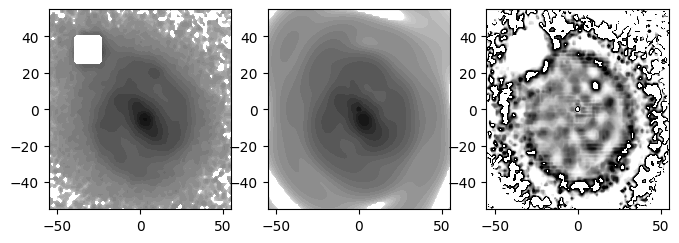

In [5]:
# make the expansion and compute the weights
LG = LaguerreAmplitudes(rscl,np.ones(rval.size),phi,snapshotflat,rval,mmax,nmax)
c, s = LG.laguerre_amplitudes_returns()
LG.laguerre_reconstruction(rr,pp)
c.shape
fig = plt.figure(figsize=(8,2.6),facecolor='white')
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

cval = np.linspace(-5.,1.,32)
ax1.contourf(xpix,ypix,np.log10(snapshot), cval,cmap=plt.cm.Greys)
ax2.contourf(xpix,ypix,np.log10(LG.reconstruction),cval,cmap=cm.Greys)

# plot the relative uncertainty (maxed out at 25 percent)
ax3.contourf(xpix,ypix,(LG.reconstruction-snapshot)/snapshot,np.linspace(-.25,.25,100),cmap=cm.Greys)

In [6]:
from mingus.containers import NoteContainer, Note
noteys = NoteContainer()
notey2 = NoteContainer()
for m in range(0,mmax):
    for n in range(0,nmax):
        print('cosine term, m = ', m, ' n = ', n, ' = ', c[m][n])
        print('sine term, m = ', m, ' n = ', n, ' = ', s[m][n])
        noteys.add_notes(Note().from_hertz(np.power(10,c[m][n])))
        notey2.add_notes(Note().from_hertz(np.power(10,s[m][n])))

cosine term, m =  0  n =  0  =  36.04936375783887
sine term, m =  0  n =  0  =  0.0
cosine term, m =  0  n =  1  =  4.1881169845109545
sine term, m =  0  n =  1  =  0.0
cosine term, m =  0  n =  2  =  0.5779643941760486
sine term, m =  0  n =  2  =  0.0
cosine term, m =  0  n =  3  =  0.5260608858655602
sine term, m =  0  n =  3  =  0.0
cosine term, m =  0  n =  4  =  -0.29535973059141396
sine term, m =  0  n =  4  =  0.0
cosine term, m =  0  n =  5  =  -1.3176727648854059
sine term, m =  0  n =  5  =  0.0
cosine term, m =  0  n =  6  =  -1.9870718408885764
sine term, m =  0  n =  6  =  0.0
cosine term, m =  0  n =  7  =  -2.147354053978993
sine term, m =  0  n =  7  =  0.0
cosine term, m =  0  n =  8  =  -1.840585268076727
sine term, m =  0  n =  8  =  0.0
cosine term, m =  0  n =  9  =  -1.2182275294900733
sine term, m =  0  n =  9  =  0.0
cosine term, m =  0  n =  10  =  -0.48579125664300776
sine term, m =  0  n =  10  =  0.0
cosine term, m =  0  n =  11  =  0.16584814225233424
sine

In [17]:
mmax*nmax, np.unique(c).shape, np.unique(s).shape

(192, (192,), (169,))

In [18]:
print('cos term notes:', noteys)
print('sin term notes:', notey2)

cos term notes: ['B--28', 'C--21', 'B--13', 'A#--11', 'B--11', 'F--10', 'B--10', 'F--9', 'C--8', 'G#--8', 'A#--8', 'C--7', 'D#--7', 'E--7', 'F--7', 'F#--7', 'G--7', 'G#--7', 'A--7', 'A#--7', 'C--6', 'C#--6', 'D--6', 'D#--6', 'E--6', 'F--6', 'F#--6', 'G--6', 'G#--6', 'A--6', 'A#--6', 'B--6', 'C--5', 'C#--5', 'D--5', 'E--5', 'F--5', 'F#--5', 'G--5', 'G#--5', 'A--5', 'A#--5', 'B--5', 'C--4', 'C#--4', 'D--4', 'D#--4', 'E--4', 'F--4', 'F#--4', 'G--4', 'G#--4', 'A--4', 'A#--4', 'C--3', 'D#--3', 'F--3', 'G--3', 'G#--3', 'A--3', 'A#--3', 'B--3', 'C--2', 'D#--2', 'E--2', 'F--2', 'G#--2', 'A--2', 'A#--2', 'G--1', 'D#-0', 'G-0', 'A-0', 'G#-1', 'A-1', 'B-1', 'A#-2', 'A-4', 'B-9', 'C-12', 'A-115']
sin term notes: ['A#--53', 'D--41', 'C#--16', 'E--11', 'F--8', 'D--7', 'D#--7', 'G--7', 'A--7', 'B--7', 'C--6', 'C#--6', 'D#--6', 'E--6', 'F#--6', 'G--6', 'G#--6', 'A--6', 'B--6', 'C--5', 'C#--5', 'D--5', 'D#--5', 'E--5', 'F--5', 'F#--5', 'G--5', 'G#--5', 'A--5', 'A#--5', 'B--5', 'C--4', 'C#--4', 'D--4', 

In [19]:
fluidsynth.set_instrument(1, 4) #3, 4, 6 are fine
fluidsynth.play_NoteContainer(noteys)
fluidsynth.play_NoteContainer(notey2)
time.sleep(1.4)
fluidsynth.stop_NoteContainer(NoteContainer(noteys))
fluidsynth.stop_NoteContainer(NoteContainer(notey2))

True

In [20]:
fluidsynth.set_instrument(1, 64) #3, 4, 6 are fine
fluidsynth.play_NoteContainer(noteys)
fluidsynth.play_NoteContainer(notey2)
time.sleep(1.4)
fluidsynth.stop_NoteContainer(NoteContainer(noteys))
fluidsynth.stop_NoteContainer(NoteContainer(notey2))

True

# Images -

(319, 319) (307, 307)


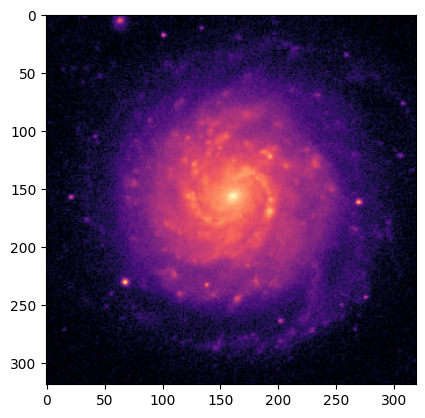

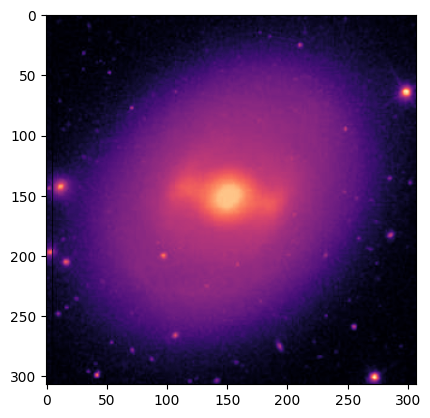

In [38]:
# loading in new figures
from PIL import Image

spiral = np.asarray(Image.open('spiral.jpeg'))
spiral = np.mean(spiral,axis=2)/np.max(spiral)#spiral[:,:,0]/spiral[:,:,0].max()
spiral = spiral[1:,1:] #for some reason, skipping this step means that flattened array mask applies to this array??
#spiral = spiral[:-1,45:257]

bar = np.asarray(Image.open('ngc936.jpg'))
#bar = bar[:,:,0]/bar[:,:,0].max()
bar = np.mean(bar, axis=2)
bar = bar/bar.max()
bar = bar[13:, 13:]
print(spiral.shape, bar.shape)


plt.imshow(spiral, cmap='magma')
plt.figure()
plt.imshow(bar, cmap='magma')

In [39]:
# construct the grid for the image
xp = np.linspace(-spiral.shape[0]/2.,spiral.shape[0]/2.,spiral.shape[0])
xpix,ypix = np.meshgrid(xp,xp)
rr,pp = np.sqrt(xpix**2+ypix**2),np.arctan2(ypix,xpix)


rval = np.sqrt(xpix**2+ypix**2).reshape(-1,)
phi  = np.arctan2(ypix,xpix).reshape(-1,)
spiralflat = spiral.reshape(-1,)

# pick a radius to not consider outside of
gvals = np.where(rval>180.)

rval[gvals]         = np.nan
phi[gvals]          = np.nan
print(spiral.shape, spiral.max())
spiralflat[gvals] = np.nan

print(spiral.shape, spiral.max())
# pick orders for the expansion
mmax = 8#8
nmax = 24#24


(319, 319) 0.8644536652835408
(319, 319) 0.8644536652835408


cosm shape (8, 101761)
Gj shape (24, 101761)
weird reshaped cosm shape (8, 1, 101761)
ditto for GJ (1, 24, 101761)
(8, 24, 101761)
returning coscoefs, sincoefs


/var/folders/l4/60k630dd5bj2p5fwtj1gg3zc0000gn/T/ipykernel_29868/1054427908.py:20: RuntimeWarning: divide by zero encountered in divide
  ax3.imshow((LG.reconstruction-spiral)/spiral,vmin=-.25,vmax=.25,cmap=cm.Greys)


Text(0.5, 1.0, 'relative uncertainty')

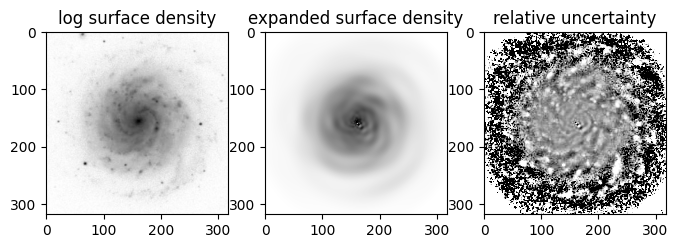

In [40]:
# pick a scalelength for the reconstruction
rscl = 10.

# make the expansion and compute the weights
LG = LaguerreAmplitudes(rscl,np.ones(rval.size),phi,spiralflat,rval,mmax,nmax)
c_spiral, s_spiral = LG.laguerre_amplitudes_returns()

LG.laguerre_reconstruction(rr,pp)
# make a figure for the comparison
fig = plt.figure(figsize=(8,2.6),facecolor='white')
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

cval = np.linspace(-5.,1.,32)
ax1.imshow((spiral), cmap=plt.cm.Greys)
ax2.imshow((LG.reconstruction),vmin=np.nanmin(spiral), vmax=np.nanmax(spiral),cmap=cm.Greys)

# plot the relative uncertainty (maxed out at 25 percent)
ax3.imshow((LG.reconstruction-spiral)/spiral,vmin=-.25,vmax=.25,cmap=cm.Greys)

ax1.set_title('log surface density')
ax2.set_title('expanded surface density')
ax3.set_title('relative uncertainty')


In [41]:
spiral

array([[0.0428769 , 0.03457815, 0.02627939, ..., 0.0055325 , 0.00968188,
        0.01383126],
       [0.02627939, 0.01798064, 0.03042877, ..., 0.03042877, 0.01383126,
        0.        ],
       [0.00968188, 0.00276625, 0.03042877, ..., 0.03872752, 0.02627939,
        0.01383126],
       ...,
       [0.02074689, 0.03319502, 0.04564315, ..., 0.01521438, 0.02351314,
        0.02766252],
       [0.00414938, 0.        , 0.01659751, ..., 0.01521438, 0.03181189,
        0.03181189],
       [0.        , 0.        , 0.00414938, ..., 0.01936376, 0.02766252,
        0.02351314]])

### fluidsynth.setting('synth.gain', 0.6)

In [45]:

from mingus.containers import NoteContainer, Note
noteys = NoteContainer()
notey2 = NoteContainer()
for m in range(0,mmax):
    for n in range(0,nmax):
        #print('cosine term, m = ', m, ' n = ', n, ' = ', c_spiral[m][n])
        #print('sine term, m = ', m, ' n = ', n, ' = ', s_spiral[m][n])
        noteys.add_notes(Note().from_hertz(np.power(10,c_spiral[m][n])))
        notey2.add_notes(Note().from_hertz(np.power(10,s_spiral[m][n])))

fluidsynth.set_instrument(1, 4) #3, 4, 6 are fine
fluidsynth.play_NoteContainer(noteys)
fluidsynth.play_NoteContainer(notey2)
time.sleep(1.4)
fluidsynth.stop_NoteContainer(NoteContainer(noteys),500)
fluidsynth.stop_NoteContainer(NoteContainer(notey2),500)

True

cosm shape (8, 94249)
Gj shape (24, 94249)
weird reshaped cosm shape (8, 1, 94249)
ditto for GJ (1, 24, 94249)
(8, 24, 94249)
returning coscoefs, sincoefs


True

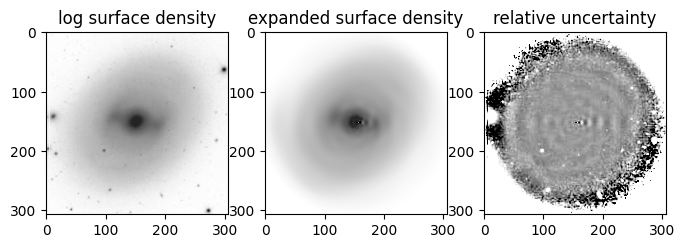

In [49]:
# construct the grid for the image
xp = np.linspace(-bar.shape[0]/2.,bar.shape[0]/2.,bar.shape[0])
xpix,ypix = np.meshgrid(xp,xp)
rr,pp = np.sqrt(xpix**2+ypix**2),np.arctan2(ypix,xpix)



rval = np.sqrt(xpix**2+ypix**2).reshape(-1,)
phi  = np.arctan2(ypix,xpix).reshape(-1,)
barflat = bar.reshape(-1,)#bar.copy().reshape(-1,)

# pick a radius to not consider outside of
gvals = np.where(rval>150.) #150

rval[gvals]         = np.nan
phi[gvals]          = np.nan
barflat[gvals] = np.nan

# pick orders for the expansion
mmax = 8
nmax = 24

# pick a scalelength for the reconstruction
rscl = 12.

# make the expansion and compute the weights
LG = LaguerreAmplitudes(rscl,np.ones(rval.size),phi,barflat,rval,mmax,nmax)
c_bar, s_bar = LG.laguerre_amplitudes_returns()

LG.laguerre_reconstruction(rr,pp)
# make a figure for the comparison
fig = plt.figure(figsize=(8,2.6),facecolor='white')
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

cval = np.linspace(-5.,1.,32)
ax1.imshow((bar),cmap=plt.cm.Greys)
ax2.imshow((LG.reconstruction),vmin=np.nanmin(bar), vmax=np.nanmax(bar),cmap=cm.Greys)

# plot the relative uncertainty (maxed out at 25 percent)
ax3.imshow((LG.reconstruction-bar)/bar,vmin=-.25, vmax=.25,cmap=cm.Greys)

ax1.set_title('log surface density')
ax2.set_title('expanded surface density')
ax3.set_title('relative uncertainty')

from mingus.containers import NoteContainer, Note
noteys = NoteContainer()
notey2 = NoteContainer()
for m in range(0,mmax):
    for n in range(0,nmax):
        #print('cosine term, m = ', m, ' n = ', n, ' = ', c_bar[m][n])
        #print('sine term, m = ', m, ' n = ', n, ' = ', s_bar[m][n])
        noteys.add_notes(Note().from_hertz(np.power(10,c_bar[m][n])))
        notey2.add_notes(Note().from_hertz(np.power(10,s_bar[m][n])))

fluidsynth.set_instrument(1, 4) #3, 4, 6 are fine
fluidsynth.play_NoteContainer(noteys)
fluidsynth.play_NoteContainer(notey2)
time.sleep(1.4)
fluidsynth.stop_NoteContainer(NoteContainer(noteys))
fluidsynth.stop_NoteContainer(NoteContainer(notey2))

cosm shape (8, 94249)
Gj shape (24, 94249)
weird reshaped cosm shape (8, 1, 94249)
ditto for GJ (1, 24, 94249)
(8, 24, 94249)
returning coscoefs, sincoefs
cosine term, m =  0  n =  0  =  56.52168831870469
sine term, m =  0  n =  0  =  0.0
cosine term, m =  0  n =  1  =  -57.67684801115128
sine term, m =  0  n =  1  =  0.0
cosine term, m =  0  n =  2  =  56.654988629366024
sine term, m =  0  n =  2  =  0.0
cosine term, m =  0  n =  3  =  -51.99078231214546
sine term, m =  0  n =  3  =  0.0
cosine term, m =  0  n =  4  =  37.58741208209045
sine term, m =  0  n =  4  =  0.0
cosine term, m =  0  n =  5  =  -20.754814385843666
sine term, m =  0  n =  5  =  0.0
cosine term, m =  0  n =  6  =  4.136030714196313
sine term, m =  0  n =  6  =  0.0
cosine term, m =  0  n =  7  =  5.471603981759375
sine term, m =  0  n =  7  =  0.0
cosine term, m =  0  n =  8  =  -4.425488957862664
sine term, m =  0  n =  8  =  0.0
cosine term, m =  0  n =  9  =  0.1723697349950651
sine term, m =  0  n =  9  =  0.

True

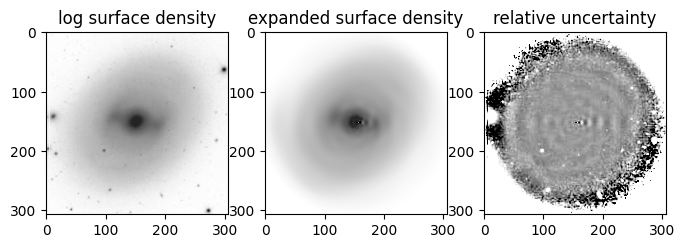

In [50]:
# construct the grid for the image
xp = np.linspace(-bar.shape[0]/2.,bar.shape[0]/2.,bar.shape[0])
xpix,ypix = np.meshgrid(xp,xp)
rr,pp = np.sqrt(xpix**2+ypix**2),np.arctan2(ypix,xpix)



rval = np.sqrt(xpix**2+ypix**2).reshape(-1,)
phi  = np.arctan2(ypix,xpix).reshape(-1,)
barflat = bar.copy().reshape(-1,)

# pick a radius to not consider outside of
gvals = np.where(rval>150.)

rval[gvals]         = np.nan
phi[gvals]          = np.nan
barflat[gvals] = np.nan

# pick orders for the expansion
mmax = 8
nmax = 24

# pick a scalelength for the reconstruction
rscl = 12.

# make the expansion and compute the weights
LG = LaguerreAmplitudes(rscl,np.ones(rval.size),phi,barflat,rval,mmax,nmax)
c_bar, s_bar = LG.laguerre_amplitudes_returns()

LG.laguerre_reconstruction(rr,pp)
# make a figure for the comparison
fig = plt.figure(figsize=(8,2.6),facecolor='white')
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

cval = np.linspace(-5.,1.,32)
ax1.imshow((bar),cmap=plt.cm.Greys)
ax2.imshow((LG.reconstruction),vmin=np.nanmin(bar), vmax=np.nanmax(bar),cmap=cm.Greys)

# plot the relative uncertainty (maxed out at 25 percent)
ax3.imshow((LG.reconstruction-bar)/bar,vmin=-.25, vmax=.25,cmap=cm.Greys)

ax1.set_title('log surface density')
ax2.set_title('expanded surface density')
ax3.set_title('relative uncertainty')

from mingus.containers import NoteContainer, Note
noteys = NoteContainer()
notey2 = NoteContainer()
for m in range(0,mmax):
    for n in range(0,nmax):
        print('cosine term, m = ', m, ' n = ', n, ' = ', c_bar[m][n])
        print('sine term, m = ', m, ' n = ', n, ' = ', s_bar[m][n])
        noteys.add_notes(Note().from_hertz(np.power(10,c_bar[m][n])))
        notey2.add_notes(Note().from_hertz(np.power(10,s_bar[m][n])))

fluidsynth.set_instrument(1, 4) #3, 4, 6 are fine
fluidsynth.play_NoteContainer(noteys)
fluidsynth.play_NoteContainer(notey2)
time.sleep(1.4)
fluidsynth.stop_NoteContainer(NoteContainer(noteys))
fluidsynth.stop_NoteContainer(NoteContainer(notey2))

In [368]:
c_bar.shape, np.unique(c_bar).shape

((8, 24), (192,))

In [362]:
Note().from_hertz()

'A-2'

In [44]:
#### from mike ---
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.special import eval_genlaguerre

def gamma_n(n,rscl):
    """define the Laguerre alpha=1 normalisation"""
    return (rscl/2.)*np.sqrt(n+1.)

def G_n(R,n,rscl):
    """define the Laguerre basis"""
    return np.exp(-R/rscl)*eval_genlaguerre(n,1,2*R/rscl)/gamma_n(n,rscl)


def n_m(m):
    """deltam0 is 0 for all orders except m=0, when it is 1.
    this is the angular normalisation."""
    deltam0 = 0.
    if m==0: deltam0 = 1.
    return np.power( (deltam0+1)*np.pi/2. , -0.5)


def laguerre_amplitudes(R,mass,phi,velocity,rscl,m,n):
    """equation 42 of WP2021
    
    force alpha=0 in the eval_genlaguerre call
    
    """
    cosm = n_m(m)*np.cos(m*phi)*velocity
    sinm = n_m(m)*np.sin(m*phi)*velocity
 
    G_j = G_n(R,n,rscl)
    
    return np.nansum(mass * G_j * cosm),np.nansum(mass * G_j * sinm) 
    

# load in the data file

(110, 110)


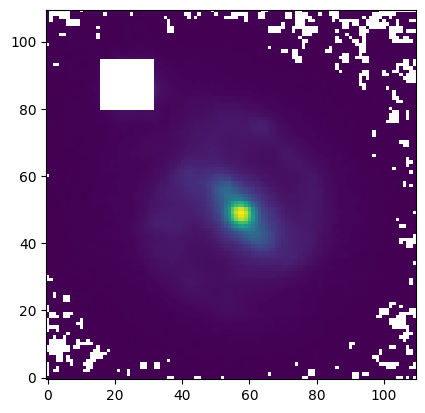

In [104]:
# load in the data file
snapshot = np.load('CEERSbar1.npy')

plt.imshow(snapshot,origin='lower')
# construct the grid for the image
xp = np.linspace(-55.,55.,110)
xpix,ypix = np.meshgrid(xp,xp)
rr,pp = np.sqrt(xpix**2+ypix**2),np.arctan2(ypix,xpix)

print(rr.shape)

In [50]:
rval = np.sqrt(xpix**2+ypix**2).reshape(-1,)
print(rval.shape)
phi  = np.arctan2(ypix,xpix).reshape(-1,)
snapshotflat = snapshot.reshape(-1,)

# pick a radius to not consider outside of
gvals = np.where(rval>50.)

rval[gvals]         = np.nan
phi[gvals]          = np.nan
snapshotflat[gvals] = np.nan

# pick orders for the expansion
mmax = 8
nmax = 24

# pick a scalelength for the reconstruction
rscl = 12.

(12100,)


In [105]:
# pick orders for the expansion
mmax = 8
nmax = 24

# pick a scalelength for the reconstruction
rscl = 12.

# zero the coefficient values to start
ffc = 0
ffs = 0

for m in range(0,mmax):
    for n in range(0,nmax):
      
        # compute the coefficients
        tmpffc,tmpffs = laguerre_amplitudes(rval,np.ones(rval.size),phi,snapshotflat,rscl,m,n)
        #print(m,n,tmpffc,tmpffs)

        # add the contribution to the output arrays
        ffc += (0.5)*tmpffc*n_m(m)*np.cos(m*pp)*G_n(rr,n,rscl)
        ffs += (0.5)*tmpffs*n_m(m)*np.sin(m*pp)*G_n(rr,n,rscl)

# reconstruct the image
snapshotreconstruction = ffc+ffs

/var/folders/l4/60k630dd5bj2p5fwtj1gg3zc0000gn/T/ipykernel_70969/3260928185.py:8: RuntimeWarning: invalid value encountered in log10
  ax2.contourf(xpix,ypix,np.log10(snapshotreconstruction),cval,cmap=cm.Greys)


Text(0.5, 1.0, 'relative uncertainty')

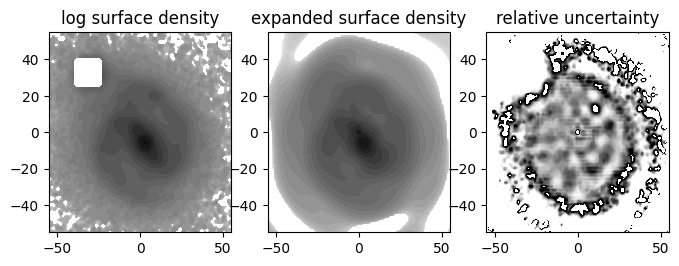

In [106]:
fig = plt.figure(figsize=(8,2.6),facecolor='white')
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

cval = np.linspace(-5.,1.,32)
ax1.contourf(xpix,ypix,np.log10(snapshot), cval,cmap=plt.cm.Greys)
ax2.contourf(xpix,ypix,np.log10(snapshotreconstruction),cval,cmap=cm.Greys)

# plot the relative uncertainty (maxed out at 25 percent)
ax3.contourf(xpix,ypix,(snapshotreconstruction-snapshot)/snapshot,np.linspace(-.25,.25,100),cmap=cm.Greys)

ax1.set_title('log surface density')
ax2.set_title('expanded surface density')
ax3.set_title('relative uncertainty')

/var/folders/l4/60k630dd5bj2p5fwtj1gg3zc0000gn/T/ipykernel_70969/1748642104.py:7: RuntimeWarning: invalid value encountered in log10
  ax1.imshow(np.log10(ffc), origin='lower')
/var/folders/l4/60k630dd5bj2p5fwtj1gg3zc0000gn/T/ipykernel_70969/1748642104.py:8: RuntimeWarning: invalid value encountered in log10
  ax2.imshow(np.log10(ffs), origin='lower')
/var/folders/l4/60k630dd5bj2p5fwtj1gg3zc0000gn/T/ipykernel_70969/1748642104.py:9: RuntimeWarning: invalid value encountered in log10
  ax3.imshow(np.log10(ffc+ffs), origin='lower')


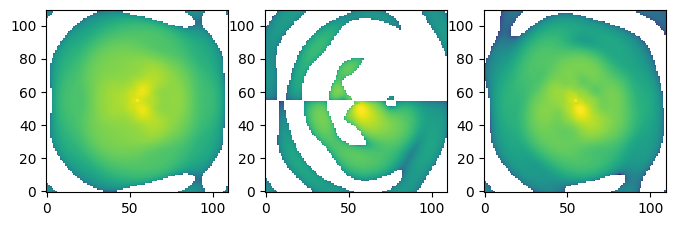

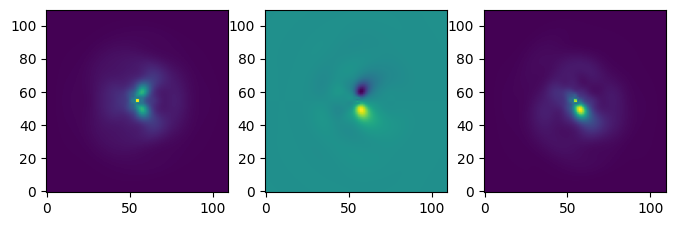

In [108]:
fig = plt.figure(figsize=(8,2.6),facecolor='white')
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

cval = np.linspace(-5.,1.,32)
ax1.imshow(np.log10(ffc), origin='lower')
ax2.imshow(np.log10(ffs), origin='lower')
ax3.imshow(np.log10(ffc+ffs), origin='lower')

fig = plt.figure(figsize=(8,2.6),facecolor='white')
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

cval = np.linspace(-5.,1.,32)
ax1.imshow(ffc, origin='lower')
ax2.imshow(ffs, origin='lower')
ax3.imshow(ffc+ffs, origin='lower')

# attempt sound --

In [109]:
# pick orders for the expansion
mmax = 8
nmax = 24

# pick a scalelength for the reconstruction
rscl = 12.

# zero the coefficient values to start
ffc = 0
ffs = 0

for m in range(0,mmax):
    for n in range(0,nmax):
      
        # compute the coefficients
        tmpffc,tmpffs = laguerre_amplitudes(rval,np.ones(rval.size),phi,snapshotflat,rscl,m,n)
        print(m,n,tmpffc,tmpffs)

        # add the contribution to the output arrays
        ffc += (0.5)*tmpffc*n_m(m)*np.cos(m*pp)*G_n(rr,n,rscl)
        ffs += (0.5)*tmpffs*n_m(m)*np.sin(m*pp)*G_n(rr,n,rscl)

# reconstruct the image
snapshotreconstruction = ffc+ffs

0 0 36.016436415479646 0.0
0 1 4.353135335060114 0.0
0 2 0.24990236668728438 0.0
0 3 0.7183164257632797 0.0
0 4 -0.11156046295150163 0.0
0 5 -1.438384989141618 0.0
0 6 -2.1821790151253104 0.0
0 7 -2.1720753576087253 0.0
0 8 -1.6994753124023525 0.0
0 9 -1.0692514973720737 0.0
0 10 -0.4545703672718948 0.0
0 11 0.07263281866537108 0.0
0 12 0.4804331053329637 0.0
0 13 0.7464921500992405 0.0
0 14 0.8584117150925391 0.0
0 15 0.8241352425942826 0.0
0 16 0.67607844487861 0.0
0 17 0.46428308455661316 0.0
0 18 0.24253393170882825 0.0
0 19 0.0542834168049752 0.0
0 20 -0.07625538005386148 0.0
0 21 -0.1458048338487326 0.0
0 22 -0.16753222910391735 0.0
0 23 -0.16315317513626681 0.0
1 0 4.840463392273066 -14.819991218291413
1 1 1.0365232389177998 -3.8968723474597424
1 2 -0.8629167334985309 0.5614804824794587
1 3 -1.1523033619551195 2.5834559418311622
1 4 -1.0290714267404928 3.537350498386881
1 5 -1.0126175859798214 3.604000171897667
1 6 -1.0683353615287134 2.955426126665223
1 7 -1.0154677097868336 1.

/var/folders/l4/60k630dd5bj2p5fwtj1gg3zc0000gn/T/ipykernel_70969/2897524612.py:7: RuntimeWarning: invalid value encountered in log10
  ax1.imshow(np.log10(ffc))
/var/folders/l4/60k630dd5bj2p5fwtj1gg3zc0000gn/T/ipykernel_70969/2897524612.py:8: RuntimeWarning: invalid value encountered in log10
  ax2.imshow(np.log10(ffs))
/var/folders/l4/60k630dd5bj2p5fwtj1gg3zc0000gn/T/ipykernel_70969/2897524612.py:9: RuntimeWarning: invalid value encountered in log10
  ax3.imshow(np.log10(ffc+ffs))
/var/folders/l4/60k630dd5bj2p5fwtj1gg3zc0000gn/T/ipykernel_70969/2897524612.py:26: RuntimeWarning: invalid value encountered in log10
  ax1.contourf(xpix,ypix,np.log10(ffc), cval,cmap=plt.cm.Greys)
/var/folders/l4/60k630dd5bj2p5fwtj1gg3zc0000gn/T/ipykernel_70969/2897524612.py:27: RuntimeWarning: invalid value encountered in log10
  ax2.contourf(xpix,ypix,np.log10(ffs),cval,cmap=cm.Greys)
/var/folders/l4/60k630dd5bj2p5fwtj1gg3zc0000gn/T/ipykernel_70969/2897524612.py:30: RuntimeWarning: invalid value encounter

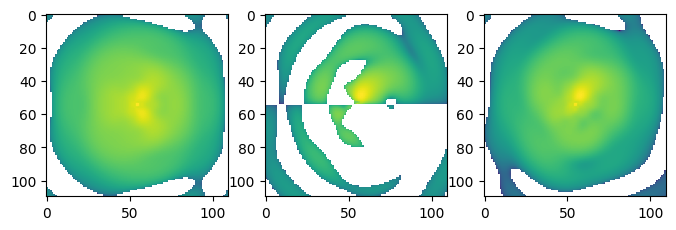

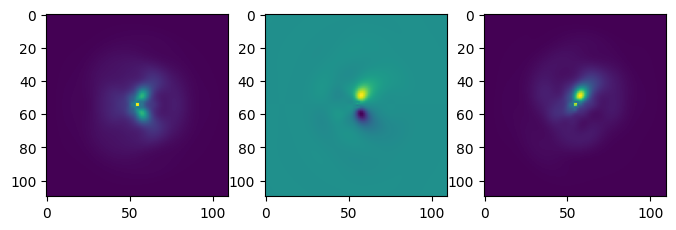

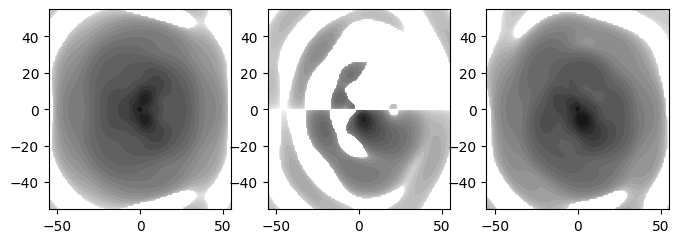

In [110]:
fig = plt.figure(figsize=(8,2.6),facecolor='white')
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

cval = np.linspace(-5.,1.,32)
ax1.imshow(np.log10(ffc))
ax2.imshow(np.log10(ffs))
ax3.imshow(np.log10(ffc+ffs))

fig = plt.figure(figsize=(8,2.6),facecolor='white')
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

cval = np.linspace(-5.,1.,32)
ax1.imshow(ffc)
ax2.imshow(ffs)
ax3.imshow(ffc+ffs)


fig = plt.figure(figsize=(8,2.6),facecolor='white')
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.contourf(xpix,ypix,np.log10(ffc), cval,cmap=plt.cm.Greys)
ax2.contourf(xpix,ypix,np.log10(ffs),cval,cmap=cm.Greys)

# plot the relative uncertainty (maxed out at 25 percent)
ax3.contourf(xpix,ypix,np.log10(ffc+ffs),cval,cmap=cm.Greys)

In [111]:
tmpffc,tmpffs = laguerre_amplitudes(rval,np.ones(rval.size),phi,snapshotflat,rscl,1,1)
tmpffc

1.0365232389177998

In [129]:
from mingus.containers import NoteContainer, Note
noteys = NoteContainer()
notey2 = NoteContainer()
for m in range(0,mmax):
    for n in range(0,nmax):
      
        # compute the coefficients
        tmpffc,tmpffs = laguerre_amplitudes(rval,np.ones(rval.size),phi,snapshotflat,rscl,m,n)
        noteys.add_notes(Note().from_hertz(np.exp(tmpffc)))
        notey2.add_notes(Note().from_hertz(np.exp(tmpffs)))

In [130]:
noteys, notey2

(['G--14', 'G#--11', 'C#--7', 'B--7', 'C--6', 'D#--6', 'E--6', 'F--6', 'F#--6', 'G--6', 'G#--6', 'A--6', 'A#--6', 'B--6', 'C--5', 'C#--5', 'D--5', 'D#--5', 'E--5', 'F--5', 'F#--5', 'G--5', 'G#--5', 'A--5', 'A#--5', 'B--5', 'C--4', 'C#--4', 'D--4', 'D#--4', 'E--4', 'F--4', 'F#--4', 'G#--4', 'A--4', 'B--4', 'C--3', 'C#--3', 'D--3', 'D#--3', 'F#--3', 'G--3', 'A#--3', 'B--3', 'C--2', 'F--2', 'F#--2', 'G--2', 'B--2', 'A#--1', 'D#-2', 'B-2', 'B-47'],
 ['G#--25', 'G--20', 'F--9', 'G--7', 'C--6', 'D#--6', 'F#--6', 'G--6', 'G#--6', 'A#--6', 'B--6', 'C--5', 'C#--5', 'D--5', 'D#--5', 'E--5', 'F--5', 'F#--5', 'G--5', 'G#--5', 'A--5', 'A#--5', 'B--5', 'C--4', 'C#--4', 'D--4', 'D#--4', 'E--4', 'F--4', 'F#--4', 'G--4', 'G#--4', 'A--4', 'C#--3', 'D--3', 'A#--3', 'C#--2', 'G#--2', 'A--2', 'C#--1', 'D#--1', 'G#--1', 'C-0', 'C#-0', 'D#-0', 'C#-1', 'D-1', 'F-1'])

In [132]:
fluidsynth.play_NoteContainer(noteys)

True

In [133]:
fluidsynth.play_NoteContainer(notey2)

True